In [1]:
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import glob
from datetime import datetime 
import tushare as ts
ts.set_token('ce1d8f98f48f0c92fa70a66528612510f350b82ea565bc1abd45b5ac')
pro = ts.pro_api()

In [2]:
import numpy as np
import pandas as pd
from numpy import abs
from numpy import log
from numpy import sign
from scipy.stats import rankdata

def ts_sum(df, window=10):
    return df.rolling(window).sum()

def sma(df, window=10):
    return df.rolling(window).mean()

def stddev(df, window=10):
    return df.rolling(window).std()

def correlation(x, y, window=10):
    return x.rolling(window).corr(y)

def covariance(x, y, window=10):
    return x.rolling(window).cov(y)

def rolling_rank(na):
    return rankdata(na)[-1]

def ts_rank(df, window=10):
    return df.rolling(window).apply(rolling_rank)

def rolling_prod(na):
    return np.prod(na)

def product(df, window=10):
    return df.rolling(window).apply(rolling_prod)

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_max(df, window=10):
    return df.rolling(window).max()

def ts_median(df, window=10):
    return df.rolling(window).median()


def delta(df, period=1):
    return df.diff(period)

def delay(df, period=1):
    return df.shift(period)

def rank(df):
    return df.rank(axis=1, pct=True)
#     return df.rank(pct=True)

def scale(df, k=1):
    return df.mul(k).div(np.abs(df).sum())

def ts_argmax(df, window=10):
    return df.rolling(window).apply(np.argmax) + 1 

def ts_argmin(df, window=10):
    return df.rolling(window).apply(np.argmin) + 1




In [3]:
pro = ts.pro_api()
all_stock = pro.stock_basic()
price_PD_total = pd.read_csv('data/price_PD.csv', dtype = {'trade_date': 'str'})
price_PD_total = price_PD_total.drop_duplicates(['ts_code', 'trade_date']).sort_values(['ts_code', 'trade_date']).reset_index(drop=True)
all_stock = all_stock[['ts_code','name','market','industry']]
price_PD_total = pd.merge(price_PD_total,all_stock,how='left',on='ts_code')
price_PD_total = price_PD_total[['ts_code', 'name','market','industry', 'trade_date', 'open', 'high', 'low',
       'close', 'pre_close','change', 'pct_chg', 'vol', 'amount']]
price_PD_total = price_PD_total[price_PD_total.market.isin(['主板','中小板','创业板'])]
price_PD_total = price_PD_total[~price_PD_total.name.str.contains('ST')].reset_index(drop=True)

In [4]:
price_PD_total['ret1'] = (price_PD_total.groupby('ts_code').pct_chg.shift(-1))/100+1


In [5]:
price_PD_total.head()

,ts_code,name,market,industry,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount,ret1
0,000001.SZ,平安银行,主板,银行,20190102,9.39,9.42,9.16,9.19,9.38,-0.19,-2.0256,539386.32,498695.109,1.009793
1,000001.SZ,平安银行,主板,银行,20190103,9.18,9.33,9.15,9.28,9.19,0.09,0.9793,415537.95,384457.707,1.050647
2,000001.SZ,平安银行,主板,银行,20190104,9.24,9.82,9.22,9.75,9.28,0.47,5.0647,1481159.06,1422149.888,0.998974
3,000001.SZ,平安银行,主板,银行,20190107,9.84,9.85,9.63,9.74,9.75,-0.01,-0.1026,865687.66,841166.430,0.991786
4,000001.SZ,平安银行,主板,银行,20190108,9.73,9.74,9.62,9.66,9.74,-0.08,-0.8214,402388.11,389247.795,1.028986


In [6]:

daily_info = {}
daily_info['open'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='open')
daily_info['close'] = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='close')
daily_info['high']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='high')
daily_info['low']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='low')
daily_info['volume']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='vol')
daily_info['amount']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='amount')
daily_info['vwap']  = (daily_info['amount']*1000)/(daily_info['volume']*100+1) 
daily_info['returns']  = pd.pivot(price_PD_total,index='trade_date', columns='ts_code', values='pct_chg') 

In [7]:
def fun(x):
    if np.isnan(x):
        return np.nan
    else:
        return min(10,int(x*10)+1)
    

In [8]:
class AlphaLib(object):
    def __init__(self, daily_info):
        self.open = daily_info['open']
        self.high = daily_info['high']
        self.low = daily_info['low']
        self.close = daily_info['close']
        self.vwap = daily_info['vwap'] 
        self.volume = daily_info['volume'] 
        self.amount = daily_info['amount']
        self.returns = daily_info['returns']

    def calcu_alpha(self):
        alpha_dict={}
        alpha_dict['alpha01']=-1*((self.close/sma(self.close,10)-1)*self.amount).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha02']=sma(self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha06']=sma((self.close/sma(self.close, 5)-1)*self.amount,5).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha07']=ts_max((self.close/sma(self.close, 15)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha08']=ts_min((self.close/ts_max(self.close, 60)-1)*self.amount,10).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha09']=ts_max((self.close/ts_min(self.close, 60)-1)*self.amount,50).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha10']=ts_max((self.close/ts_min(self.close, 20)-1)*self.amount,15).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha12']=ts_max((ts_max(self.high,30)/ts_min(self.low, 30)-1)*self.amount,20).div(self.amount.sum(1),axis=0)
        alpha_dict['alpha13']=ts_max(self.high-self.low, 30)/ts_min(self.close+self.open, 30)
        alpha_dict['alpha14']=ts_sum(self.amount*(self.close-self.open), 5)
        alpha_dict['alpha15']=ts_max(self.amount*(self.high-self.low), 15)
        alpha_dict['alpha16']=ts_sum(self.amount*(self.close-self.vwap), 5)
        alpha_dict['alpha17']=ts_min(self.amount*(self.low-self.vwap), 15)
        alpha_dict['alpha18']=ts_min(self.amount*(self.open-self.vwap), 15)
        alpha_dict['alpha19']=ts_min(self.amount*(self.open-self.low), 10)
        alpha_dict['alpha20']=ts_max(self.amount*(self.close-self.low), 10)
        alpha_dict['alpha21']=ts_median(self.amount,15)/ts_sum(self.amount,15)
        alpha_dict['alpha23']=ts_max(self.amount,15)/ts_min(self.amount,10)
        alpha_dict['alpha24']=ts_sum(self.amount.div(self.amount.sum(1),axis=0),5)
    
        alpha_dict['alpha28']=(ts_max(self.close,5)/delay(self.close,5))*ts_min(self.close,5)/self.close
      
        tmp2=abs((self.close-self.open)/(self.high-self.low+0.01))
        alpha_dict['alpha29']=ts_max(tmp2,6)/ts_min(tmp2,6)
        alpha_dict['alpha30']=tmp2/delay(tmp2,4)

        tmp3=abs((self.low-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha31']=ts_max(tmp3,4)/ts_min(tmp3,4)

        tmp4=abs((self.high-self.open)/(self.close-self.low+0.01))
        alpha_dict['alpha32']=ts_max(tmp4,2)/ts_min(tmp4,2)
        
        alpha_dict['alpha_w_005'] = -1*(rank((self.open - (ts_sum(self.vwap, 10) / 10))) * (-1 * abs(rank((self.close - self.vwap)))))
    
        return  alpha_dict
        

In [9]:
tmp_class = AlphaLib(daily_info)
alpha_dict = tmp_class.calcu_alpha()

In [10]:
alpha = alpha_dict['alpha_w_005'].unstack().reset_index().rename(columns={0:'factor'})
# alpha = alpha.dropna()


In [11]:
alpha = pd.merge(alpha, price_PD_total[['trade_date', \
        'ts_code','ret1','industry']], how='left', on=['trade_date', 'ts_code'])

In [12]:
alpha['factor_rank'] = alpha.groupby(['trade_date','industry']).factor.rank(pct=True,method='dense')


In [13]:
alpha

,ts_code,trade_date,factor,ret1,industry,factor_rank
0,000001.SZ,20190102,NaN,1.009793,银行,NaN
1,000001.SZ,20190103,NaN,1.050647,银行,NaN
2,000001.SZ,20190104,NaN,0.998974,银行,NaN
3,000001.SZ,20190107,NaN,0.991786,银行,NaN
4,000001.SZ,20190108,NaN,1.028986,银行,NaN
...,...,...,...,...,...,...
6513595,605599.SH,20250122,0.530309,1.001835,服饰,0.949153
6513596,605599.SH,20250123,0.567742,1.012821,服饰,0.966102
6513597,605599.SH,20250124,0.486858,1.016275,服饰,0.932203
6513598,605599.SH,20250127,0.619445,0.959964,服饰,0.966667


In [14]:
alpha['factor_rank_bin'] = alpha.factor_rank.apply(fun)

In [15]:
alpha.factor_rank_bin.value_counts()

10.0    653010
6.0     593355
3.0     579761
9.0     577083
7.0     572092
8.0     562517
2.0     559863
4.0     554871
5.0     545297
1.0     474915
Name: factor_rank_bin, dtype: int64

<AxesSubplot:xlabel='trade_date'>

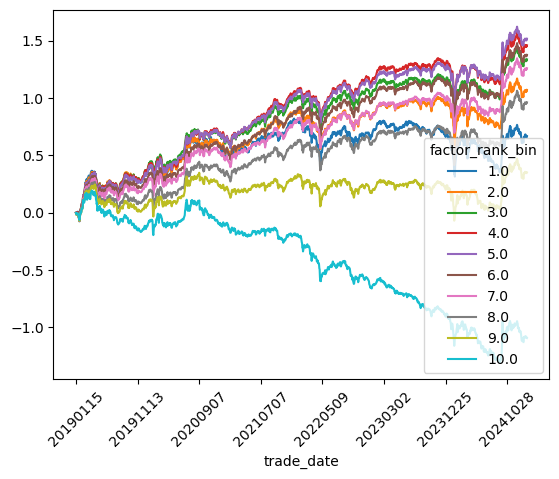

In [16]:
(alpha.groupby(['factor_rank_bin', \
        'trade_date']).ret1.mean()-1).unstack().T.cumsum().plot(rot=45)

<AxesSubplot:xlabel='trade_date'>

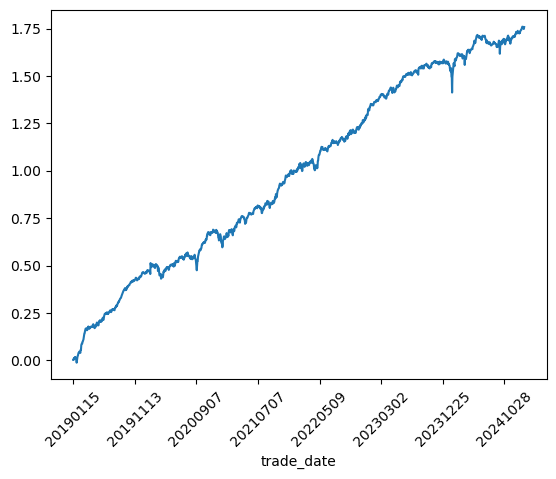

In [17]:
##计算做多做空收益
##做多factor最大的一组，做空factor最小的一组

long_ret = (alpha[(alpha.factor_rank_bin == 1)].groupby('trade_date').ret1.mean()-1).cumsum()
short_ret = (alpha[(alpha.factor_rank_bin == 10)].groupby('trade_date').ret1.mean()-1).cumsum()
(long_ret - short_ret).plot(rot=45)

In [18]:
ret_PD = (alpha.groupby(['factor_rank_bin', 'trade_date']).ret1.mean()-1.00).unstack().T

if ret_PD[1.0].mean()>ret_PD[10].mean():
    ret_PD['diff'] = ret_PD[1.0] - ret_PD[10]
else:
    ret_PD['diff'] = ret_PD[10] - ret_PD[1.0]


In [19]:
def max_dd(returns):
    r = returns.cumsum()+1
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = returns.index[dd.argmin()]
    start = returns.index[r.loc[:end].argmax()]
    return mdd, start, end
 

def calc_pfmc(ret_PD):
    performance = []
    for i in [1,2,3,4,5,6,7,8,9,10,'diff']:
        returnlist = ret_PD[i]
        ret_year = (returnlist.mean()-0)*252
        ret_sharpe = (returnlist.mean()-0)/returnlist.std()*(252**0.5)
        max_draw, start, end = max_dd(returnlist)
        winratio = (returnlist>0).sum()/len(returnlist)
        std = returnlist.std()
        performance.append([i,ret_year,ret_sharpe,std,winratio,max_draw])
    performance = pd.DataFrame(performance,columns = ['group_name','return','sharpe',\
                    'std','winratio','mdd'])
    return performance

calc_pfmc(ret_PD)

,group_name,return,sharpe,std,winratio,mdd
0,1,0.114745,0.431025,0.016770,0.530014,-0.277923
1,2,0.184395,0.719861,0.016136,0.543656,-0.209688
2,3,0.230164,0.917319,0.015806,0.545020,-0.175619
3,4,0.251290,1.004640,0.015757,0.554570,-0.164757
4,5,0.261215,1.060884,0.015511,0.558663,-0.151056
5,6,0.236959,0.977607,0.015269,0.560709,-0.161025
6,7,0.216875,0.900373,0.015174,0.559345,-0.171340
7,8,0.165704,0.697874,0.014957,0.551842,-0.195983
8,9,0.060505,0.260777,0.014616,0.524557,-0.309834
9,10,-0.187818,-0.833702,0.014191,0.489086,-1.257361


In [20]:
ICvalue = alpha.groupby(['trade_date'])[['factor','ret1']].corr()['factor'].reset_index()
ICvalue = ICvalue[ICvalue.level_1=='ret1']
ICvalue = ICvalue[['trade_date','factor']].set_index('trade_date')

<AxesSubplot:xlabel='trade_date'>

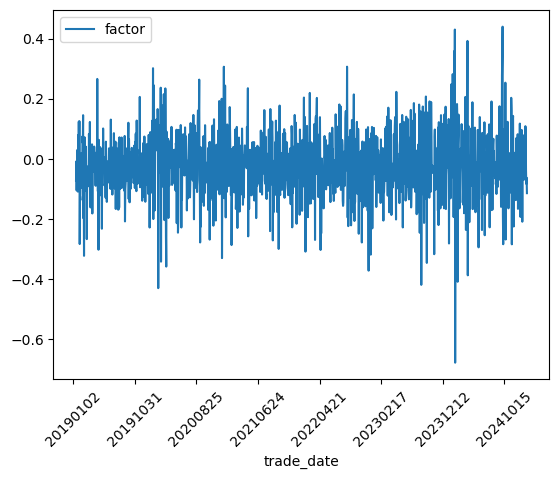

In [21]:
ICvalue.plot(rot=45)

In [22]:
display(ICvalue.mean())
display(ICvalue.mean()/ICvalue.std())

factor   -0.019308
dtype: float64

factor   -0.180449
dtype: float64